In [153]:
import TO_sim.Q_simul as QSIM
# import TO_sim.analytical.order_sec_parameter as OSP
import TO_sim.analytical.sec_order_parameter2 as OSP2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from scipy.integrate import quad
from scipy import interpolate

In [ ]:
import imp
imp.reload(QSIM)
imp.reload(OSP2)


<module 'TO_sim.analytical.sec_order_parameter2' from 'c:\\Users\\kim9y\\Desktop\\Kuramoto\\Kuramoto-model\\TO_sim\\analytical\\sec_order_parameter2.py'>

In [ ]:
K_ = np.linspace(0,15,1000)

In [193]:
m = 7
F_RMd,F_RMu,F_R0d,F_R0u =  OSP2.Make_R_function(m)
N = 1000
K = 5
Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=1000,start_p=True)

sol = Qsimul.solve()
# cluster_info = Qsimul.get_cluster()
# r_clu_info = Qsimul.get_r_clu()


In [194]:
cluster_info = Qsimul.get_cluster()
r_clu_info = Qsimul.get_r_clu()

In [195]:
O_0 = Qsimul.omega[cluster_info['c_cluster']['0']].max()
O_20 = Qsimul.omega[cluster_info['c_cluster']['+']].max()

In [238]:
O_0 ,O_20

(0.7729356931282201, 1.3989160405098888)

In [232]:
RM = F_R0u(K)
r0 = r_clu_info['r_clu_mean']['0'][-1]
rp = r_clu_info['r_clu_mean']['+'][-1]
O_O = 4/np.pi * np.sqrt(r0*K/m) - 0.3056*1/np.sqrt(K*r0*m**3)
print(O_O)

0.8110716484575914


In [233]:
K_ = np.linspace(0,15,30000)

In [234]:
cross_point = np.sign((F_R0u(K_)[0:-1]-RM)*(F_R0u(K_)[1:]-RM))*(-0.5) + 0.5
arg_check, = np.where(cross_point==1)

K_match = (K_[arg_check] +K_[arg_check+1])/2

In [235]:
# O_O = 4/np.pi * np.sqrt(F_RMu(K_match)*K_match/m) - 0.3056*1/np.sqrt(K_match*F_RMu(K_match)*m**3)
O_O = 4/np.pi * np.sqrt(F_R0u(K_match)*K_match/m) - 0.3056*1/np.sqrt(K_match*F_R0u(K_match)*m**3)
print(O_O)

[0.76374926]


In [236]:
RP = norm.cdf(O_20) - norm.cdf(O_0)
R0 = norm.cdf(O_0) - norm.cdf(-O_0)
shift_O = (K**2*R0*RP)/(2*m*(1/m**2+(O_O)**2)) + (K**2*RP*RP)/(2*m*(1/m**2+(O_O)**2))
print(shift_O)

[0.28722372]


In [237]:
shift_O = (K**2*r0*rp)/(2*m*(1/m**2+(O_O)**2)) + (K**2*rp*rp)/(2*m*(1/m**2+(O_O)**2))
print(shift_O)


[0.28905734]


In [231]:
K_match

array([4.99991666])

In [150]:
K_ = 4.8

In [161]:
b = 0.1
x = np.linspace(0,shift_O,1000)
RP_ = norm.cdf(x+K_*b+O_0) - norm.cdf(O_0)

x_ = (K_**2*R0*RP_)/(2*m*(1/m**2+(O_O)**2)) + (K_**2*RP_*RP_)/(2*m*(1/m**2+(O_O)**2))
# quad(lambda x: norm.pdf(x)*np.sqrt(1-x/(K_*R0)),-O_0,O_0)


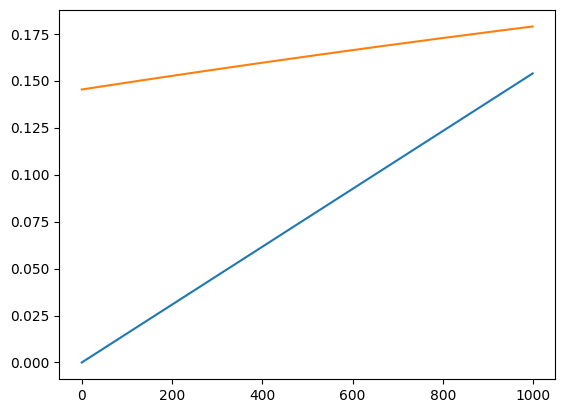

In [162]:
plt.plot(x)
plt.plot(x_)

In [164]:
cross_point = np.sign((x[0:-1]-x_[0:-1])*(x[1:]-x_[1:]))*(-0.5) + 0.5
try:
    arg_check, = np.where(cross_point==1)[0]
    arg_check
    x[arg_check]
    x__ = (x[arg_check] +x[arg_check+1])/2
except ValueError:
    x__ = 0

In [157]:
F0_RMd,F0_RMu,F0_R0d,F0_R0u =  OSP2.Make_R0_function(m,O_0)

In [158]:
Ks_back = np.arange(0,K,0.1)

In [159]:
def g_sec(x,Or,Om):
    g = norm.pdf(x,-Or,1)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)
def F_sec0(r,r_last,K,shift_O,m,O_0,O_20,F_R0,g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    r_0 = F_R0(K)
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)
    a0 = 1/np.sqrt(K*r_0*m)
    # O_pm = (4/np.pi * a0 - 0.3056*a0**3)*K*r_0
    O_pm = O_0
    O_d = O_20-(O_0-shift_O)
    if K*r<=O_d:
        # r_last = norm.cdf(O_0)

        # r_s = np.linspace(norm.cdf(O_0),norm.cdf(O_0)+r,10000,endpoint=False)
        r_s = np.linspace(r_last/2+0.5,r_last/2+0.5+r,20000,endpoint=False)
        # r_s = np.linspace(r_last,r_last+r,20000,endpoint=False)
        A = norm.ppf(r_s)
        O_r = np.mean(A)
        # shift_O = -(K**2*r*r_last)/(2*m*(1/m**2+(O_pm)**2)) -(K**2*r*r)/(2*m*(1/m**2+(O_pm)**2))
        shift_O = -abs(O_r-O_0)
        # print(shift_O)
        O_d = min(O_d,K*r)
    elif bs*K*r>O_d:
        # r_last = norm.cdf(O_0)
        r_s = np.linspace(r_last/2+0.5,r_last/2+0.5+r,20000,endpoint=False)
        # r_s = np.linspace(r_last,r_last+r,20000,endpoint=False)
        A = norm.ppf(r_s)
        O_r = np.mean(A)
        O_d = bs*K*r
    O_d2 = np.where(O_d<K*r,O_d,K*r)
    O_SD =(K*r_0/2-(O_0-shift_O))
    if O_SD<0:
        O_d = 0
    integrand_drift = lambda x:1/(2*(m*(x+O_pm-shift_O)**2+1/m))*g(x,O_pm-shift_O,O_pm)
    integrand_lock = lambda x:g(x,O_pm-shift_O,O_pm)*np.sqrt(1-((x)/X)**2)

    I_d,err = quad(integrand_drift,+O_d,np.inf,limit=200)
    I_l,err = quad(integrand_lock, -O_d,+O_d,limit=200)
    return I_l/X-I_d,I_l/X,-I_d

get_F20 = np.vectorize(F_sec0)

In [172]:


def F_sec0(r,r_last,K,shift_O,m,O_0,O_20,F_R0,g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    r_0 = F_R0(K)
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)
    a0 = 1/np.sqrt(K*r_0*m)
    # O_pm = (4/np.pi * a0 - 0.3056*a0**3)*K*r_0
    O_pm = O_0
    O_d = O_20-(O_0-shift_O)
    if K*r<=O_d:
        x = np.linspace(0,-shift_O,1000)
        RP_ = norm.cdf(x+K_*r+O_0) - norm.cdf(O_0)
        x_ = (K_**2*R0*RP_)/(2*m*(1/m**2+(O_O)**2)) + (K_**2*RP_*RP_)/(2*m*(1/m**2+(O_O)**2))
        cross_point = np.sign((x[0:-1]-x_[0:-1])*(x[1:]-x_[1:]))*(-0.5) + 0.5
        try:
            arg_check, = np.where(cross_point==1)[0]
            arg_check
            x[arg_check]
            shift_O = - (x[arg_check] +x[arg_check+1])/2
        except ValueError:
            shift_O = np.nan
        # print(shift_O)
        O_d = min(O_d,K*r)
    
    O_d2 = np.where(O_d<K*r,O_d,K*r)
    O_SD =(K*r_0/2-(O_0-shift_O))
    if O_SD<0:
        O_d = 0
    integrand_drift = lambda x:1/(2*(m*(x+O_pm-shift_O)**2+1/m))*g(x,O_pm-shift_O,O_pm)
    integrand_lock = lambda x:g(x,O_pm-shift_O,O_pm)*np.sqrt(1-((x)/X)**2)

    I_d,err = quad(integrand_drift,+O_d,np.inf,limit=200)
    I_l,err = quad(integrand_lock, -O_d,+O_d,limit=200)
    return I_l/X-I_d,I_l/X,-I_d

def get_r_sec0(K,r_last,shift_O,m,O_0,O_20,FR,samples=200):
    r0_ =  FR(K)
    r_sd,r_su = np.nan,np.nan
    r_sd_l,r_su_l = np.nan,np.nan
    mu = np.nan
    md = np.nan
    if (K == 0)or (m==0):
        return r_sd,r_su,r_sd_l,r_su_l
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F2,Fl,Fd = get_F20(r_test,r_last,K,shift_O,m,O_0,O_20,FR)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    Rl_interpolate  = interpolate.interp1d(r_test,Fl, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
    Fs = R2_interpolate(r_test2)
    Fls = Rl_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    F_ls = (Fls[arg_check] +Fls[arg_check+1])/2
    if len(r_sec)>=3:
        r_su = r_sec[-1]
        r_su_l = F_ls[-1]*K*r_su
    if len(r_sec)==2:
        r_sd,r_su = r_sec
        r_sd_l,r_su_l = F_ls[0]*K*r_sd,F_ls[1]*K*r_su

    if len(r_sec)==1:
        r_su = r_sec
        r_su_l = F_ls*K*r_su
    return r_sd,r_su,r_sd_l,r_su_l
get_r_sec0_np = np.vectorize(get_r_sec0)

In [155]:
x__

array([0.07214885])

In [125]:
F_R0u(K)

array(0.66151813)

In [178]:
Qsimul.Theta_last

array([-9.85698420e+03, -9.25509658e+03, -8.87921878e+03, ...,
        2.94557871e+00,  3.10667172e+00,  3.45223213e+00])

In [216]:
Theta_last = Qsimul.Theta_last
TLO_back_info = Qsimul.TLO_back(Theta_last,K)

In [217]:
Ks_back = TLO_back_info['Ks']
r_info_back = TLO_back_info['r_info']
cluster_info_back = TLO_back_info['r_info']

In [223]:
_,_,rs_d,rs_u,_,_= OSP2.get_r_sec_np(Ks_back+3,m,F_RMu,samples=30) 

In [225]:
np.where(rs_u - rp<0)

(array([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
        45, 46, 47, 48, 49, 50], dtype=int64),)

In [226]:
Ks_back[28]+3

5.800000000000001

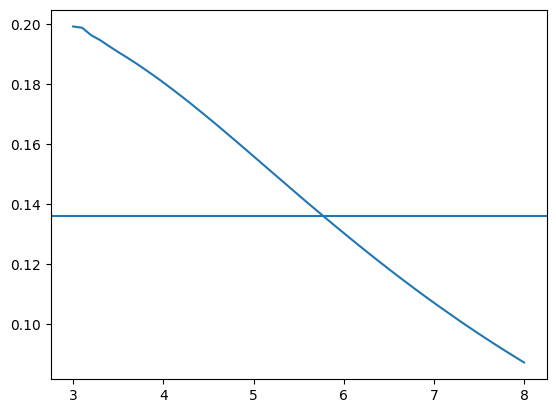

In [224]:
plt.plot(Ks_back[28]+3,rs_u)
plt.axhline(rp)

In [212]:
d,u,rs_db2,rs_ub2= get_r_sec0_np(Ks_back,r0,-shift_O,m,O_O,O_20,F0_R0u,samples=30)

In [214]:
d,u,rs_db3,rs_ub3= OSP2.get_r_sec0_np(Ks_back,r0,-shift_O,m,O_O,O_20,F0_R0u,samples=30)


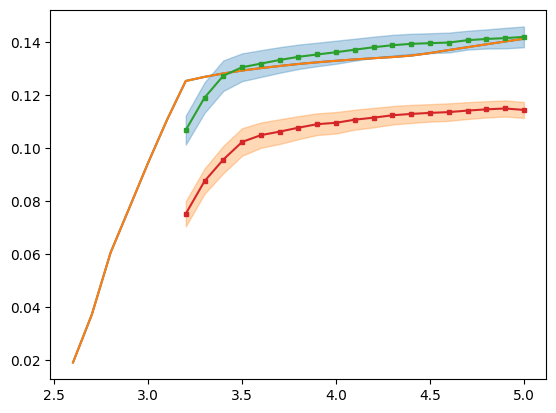

In [218]:
plt.plot(Ks_back,rs_ub2)
plt.plot(Ks_back,rs_ub3)
# plt.plot(Ks_back,rs_db2)
plt.plot(r_info_back[['r+','r-']],marker='s',markersize=3)
# plt.plot(r_info_back[['r+_total','r-_total']],marker='s',markersize=3)
plt.fill_between(r_info_back['r+'].index,(r_info_back['r+']-r_info_back['sig+']).to_numpy(float),
                 (r_info_back['r+']+r_info_back['sig+']).to_numpy(float),color='tab:blue',alpha=0.3)

plt.fill_between(r_info_back['r-'].index,(r_info_back['r-']-r_info_back['sig-']).to_numpy(float),
                 (r_info_back['r-']+r_info_back['sig-']).to_numpy(float),color='tab:orange',alpha=0.3)

In [115]:
RM

0.681112286313424

In [117]:
-(K**2*R0*Rp)/(2*m*(1/m**2+(O_O)**2)) -(K**2*Rp*Rp)/(2*m*(1/m**2+(O_O)**2))

-0.13798226838054573

In [109]:
shift_O

-0.16591935948263253

In [76]:
np.where(cross_point==1)

(array([3474], dtype=int64),)

In [78]:
K_match

array([5.21227123])

In [67]:
norm.ppf(RM/2+0.5)

0.9967462095870031

In [66]:
O_O

1.0359869081298256

In [99]:
_,_,rs_d,rs_u,_,_= OSP2.get_r_sec_np(K,m,F_RMu,samples=30) 


In [100]:
r_clu_info['r_clu_mean']['-'][-1],rs_u

(0.08061271388455603, array([0.08277836]))

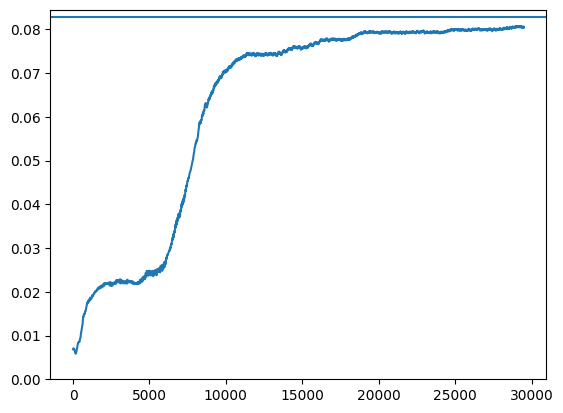

In [101]:
plt.plot(r_clu_info['r_clu_mean']['-'])
plt.axhline(rs_u)
plt.ylim(0)
plt.show()


In [19]:
r_clu_info['r_clu_mean']

{'0': array([0.02757801, 0.02758344, 0.02758615, ..., 0.60905884, 0.60905467,
        0.60905097]),
 '+_total': array([0.0123671 , 0.01235182, 0.01233835, ..., 0.03667878, 0.03664274,
        0.03660761]),
 '-_total': array([0.01330191, 0.01329543, 0.01328871, ..., 0.03972352, 0.03971624,
        0.03970582])}